<h2><font style="font-weight:lighter", color='960018'>Вступ</font></h2>

В исходных данных (Data.csv) приведены факты транзакций за период с 18.01 по 14.02.2016  по 10 магазинам сети со следующими полями:
    <li>Магазин
    <li>Код чека
    <li>Дата
    <li>Время<br><br>
Также дополнительно прилагается файл (Stores.csv) с характеристиками магазина:<br>
     <li>Город
     <li>График работы<br><br>
Требуется:<br>
        <li>Для отдела продаж построить план (прогноз) количества транзакций для каждого магазина. Задекларировать точность прогнозирования модели (MAPE).
        <li>На основании прогноза продаж необходимо для отдела персонала  построить план-график выходов сотрудников в соответствии с ранее заданами правилами.


<h2><font style="font-weight:lighter", color='960018'>Импорт библиотек и данных</font></h2>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline
from prophet import Prophet

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_data = pd.read_csv('Data.csv', sep=',', encoding='utf-8')
df_stores = pd.read_csv('Stores.csv', sep=',', encoding='utf-8')

In [3]:
df_data.head()

,Idчека,Дата,Время,Магазин
0,8C5EFA0656C5A0A011E5BD6650B1D05A,18.01.2016,7:20:33,Магазин 4
1,8C5EFA0656C5A0A011E5BD6650B1D05C,18.01.2016,8:26:38,Магазин 4
2,8C5EFA0656C5A0A011E5BD6650B1D05D,18.01.2016,9:01:32,Магазин 4
3,8C5EFA0656C5A0A011E5BD6650B1D05E,18.01.2016,9:39:09,Магазин 4
4,8C5EFA0656C5A0A011E5BD6650B1D05F,18.01.2016,9:42:12,Магазин 4


In [4]:
df_stores.head()

,Магазин,Город,РежимРаботы
0,Магазин 1,Днепропетровск,Круглосуточный
1,Магазин 2,Днепропетровск,Круглосуточный
2,Магазин 3,Днепродзержинск,Пн-Чт 10-22; Пт 10-23; Сб 09-23; Вс 09-22
3,Магазин 4,Днепропетровск,Круглосуточный
4,Магазин 5,Киев,Пн-Чт 10-22; Пт 10-23; Сб 09-23; Вс 09-22


<b>Для удобного анализа данных соединим 2 таблицы в одну по полю "Магазин"</b>

In [5]:
df = pd.merge(df_data, df_stores)

<h2><font style="font-weight:lighter", color='960018'>Разведочный анализ данных</font></h2>

In [6]:
df.head()

,Idчека,Дата,Время,Магазин,Город,РежимРаботы
0,8C5EFA0656C5A0A011E5BD6650B1D05A,18.01.2016,7:20:33,Магазин 4,Днепропетровск,Круглосуточный
1,8C5EFA0656C5A0A011E5BD6650B1D05C,18.01.2016,8:26:38,Магазин 4,Днепропетровск,Круглосуточный
2,8C5EFA0656C5A0A011E5BD6650B1D05D,18.01.2016,9:01:32,Магазин 4,Днепропетровск,Круглосуточный
3,8C5EFA0656C5A0A011E5BD6650B1D05E,18.01.2016,9:39:09,Магазин 4,Днепропетровск,Круглосуточный
4,8C5EFA0656C5A0A011E5BD6650B1D05F,18.01.2016,9:42:12,Магазин 4,Днепропетровск,Круглосуточный


<b>Сравним размеры всех таблиц, чтобы убедиться, что данные не были потеряны</b>

In [7]:
print(f'Shape of df_data -> {df_data.shape}\nShape of df_stores -> {df_stores.shape}\nShape of df -> {df.shape}')

Shape of df_data -> (45264, 4)
Shape of df_stores -> (10, 3)
Shape of df -> (45264, 6)


<b>Для удобного образения к отдельным полям таблицы, переименую названия полей на английский

In [8]:
df.rename(columns = {'Idчека':'Idcheck', 'Дата':'Date', 'Время':'Time', 'Магазин':'Shop',
                      'Город':'City', 'РежимРаботы':'Workingmode'}, inplace = True )

<b>Проверим данные на повторения и пропуски (Null значения)

In [9]:
df.isnull().sum()

Idcheck        0
Date           0
Time           0
Shop           0
City           0
Workingmode    0
dtype: int64

In [10]:
df.duplicated().sum()

0

<b>Чтобы проверить зависимость переменных (кореляцию) переведем столбец Time в более удобный для нас формат. Если чек был зарегестрирован в 7:05 то он будет относиться к 7-ому часу

In [11]:
for i in range(df.shape[0]):
    df.Time.iloc[i] = pd.Timestamp(df.Time.iloc[i]).hour

<b>Проверим, что весь столбец Time изменил значения

In [12]:
df.Time.unique()

array([7, 8, 9, 0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23,
       19, 3, 2, 4, 5, 6], dtype=object)

<b>Сделаем групировку данных, для каждой даты (Date) и для каждого часа (Time) узнаем количество чеков, а так же используем поля Shop, City, Workingmode для более подробной информации

In [13]:
df_help = df.groupby(by=['Date', 'Shop', 'City', 'Workingmode', 'Time']).agg({'Idcheck': 'count'})
df_help = df_help.reset_index()

In [14]:
df_help.head()

,Date,Shop,City,Workingmode,Time,Idcheck
0,01.02.2016,Магазин 1,Днепропетровск,Круглосуточный,0,2
1,01.02.2016,Магазин 1,Днепропетровск,Круглосуточный,1,4
2,01.02.2016,Магазин 1,Днепропетровск,Круглосуточный,2,1
3,01.02.2016,Магазин 1,Днепропетровск,Круглосуточный,5,3
4,01.02.2016,Магазин 1,Днепропетровск,Круглосуточный,6,2


<b>Модели, которые подходят для решения даной задачи, могут работать только с форматом int/float поэтому переведем столбци Shop, Workingmode, City в числовой формат, Магазин 1 -> 1, Магазин 2 -> 2 и т.д

In [15]:
dict_shop = {}
for i, item in enumerate(df_help.Shop.unique()):
    dict_shop[item] = i
for i in range(df_help.shape[0]):
    df_help.Shop.iloc[i] = int(dict_shop[df_help.Shop.iloc[i]])

In [16]:
dict_mode = {}
for i, item in enumerate(df_help.Workingmode.unique()):
    dict_mode[item] = i
for i in range(df_help.shape[0]):
    df_help.Workingmode.iloc[i] = int(dict_mode[df_help.Workingmode.iloc[i]])

In [17]:
dict_city = {}
for i, item in enumerate(df_help.City.unique()):
    dict_city[item] = i
for i in range(df_help.shape[0]):
    df_help.City.iloc[i] = int(dict_city[df_help.City.iloc[i]])

<AxesSubplot:>

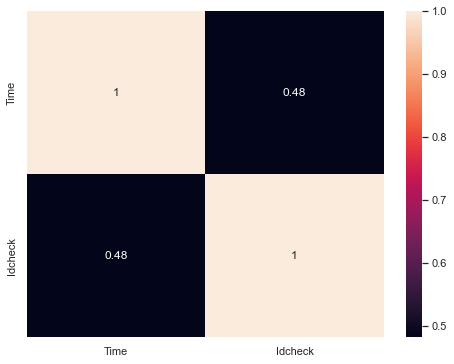

In [18]:
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(df_help.corr(), annot=True)

<b>Переведём все столбци кроме Date в тип category. Date переведём в тип  datetime

In [19]:
df_help.Date = pd.to_datetime(df_help.Date)

df_help.Shop = df_help.Shop.astype('category')
df_help.City = df_help.City.astype('category')
df_help.Workingmode = df_help.Workingmode.astype('category')
df_help.Time = df_help.Time.astype('category')

In [20]:
df_help.dtypes

Date           datetime64[ns]
Shop                 category
City                 category
Workingmode          category
Time                 category
Idcheck                 int64
dtype: object

<h2><font style="font-weight:lighter", color='960018'>Создание модели</font></h2>

<b>Для решения задач с числовыми рядами используют библиотеку Prophet, но так как количество данных невелико и не нужно учитывать глобальные праздники, было принято решение её не использовать

In [21]:
X = df_help[['Date', 'Time', 'City', 'Shop', 'Workingmode']]
y = df_help['Idcheck']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

<b>Проверим какие показатели выдают разные модели

In [22]:
X_temp = X_test
X_train = X_train.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)
models = [ExtraTreesRegressor(), LinearRegression(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor(), Lasso()]
rows = []
for clf in models:
    clf.fit(X_train, y_train) 
    print(f'\n {clf}')
    time = %time clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)    
    rows.append([clf, round(mean_absolute_percentage_error(y_pred, y_test), 2), round(clf.score(X_test,y_test), 4)])

    
model_df = pd.DataFrame(rows, columns=['Model name', 'Test MAPE', 'Model test_score'])


 ExtraTreesRegressor()
CPU times: user 254 ms, sys: 705 µs, total: 254 ms
Wall time: 85.6 ms

 LinearRegression()
CPU times: user 742 µs, sys: 1 µs, total: 743 µs
Wall time: 747 µs

 Ridge()
CPU times: user 486 µs, sys: 0 ns, total: 486 µs
Wall time: 488 µs

 DecisionTreeRegressor()
CPU times: user 1.36 ms, sys: 0 ns, total: 1.36 ms
Wall time: 1.37 ms

 RandomForestRegressor()
CPU times: user 101 ms, sys: 793 µs, total: 101 ms
Wall time: 101 ms

 Lasso()
CPU times: user 752 µs, sys: 137 µs, total: 889 µs
Wall time: 735 µs


<b>Изучим результаты, для этого был создан датафрейм для удобного просмотра и сравнения результатов

In [23]:
model_df

,Model name,Test MAPE,Model test_score
0,"(ExtraTreeRegressor(random_state=1962944919), ...",0.43,0.7397
1,LinearRegression(),1.32,0.3503
2,Ridge(),1.30,0.3502
3,DecisionTreeRegressor(),0.43,0.7397
4,"(DecisionTreeRegressor(max_features=1.0, rando...",0.43,0.7402
5,Lasso(),0.81,0.2935


<b>Лучше всего себя показали модели ExtraTreeRegressor и DecisionTreeRegressor, поэтому было принято решение остановиться на модели DecisionTreeRegressor и попытаться улучшить её с помощью GridSearch

In [24]:
parameters = {'max_depth':range(0, 50, 10), 
              'min_samples_split': range(0, 100, 2),
              'max_leaf_nodes':range(0, 100, 2)}

model = DecisionTreeRegressor()

Best_model= GridSearchCV(model, parameters, cv=5)
Best_model.fit(X_train,y_train)

print(f'Best parameters: {Best_model.best_estimator_}')

Best parameters: DecisionTreeRegressor(max_depth=10, max_leaf_nodes=54, min_samples_split=32)


<b>Поексперементировав с параметрами, было обнаружено что max_depth=10, min_samples_split=2, max_leaf_nodes=102 лучше чем выдал GridSearch

In [25]:
model = DecisionTreeRegressor(max_depth=10,
                           min_samples_split=2,
                           max_leaf_nodes=102)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 
print(f'-----------DecisionTreeRegressor-----------\n'
      f'MAPE: {mean_absolute_percentage_error(y_pred.round(), y_test)}\n'
      f'Model test_score: {model.score(X_test, y_test)}\n')

-----------DecisionTreeRegressor-----------
MAPE: 0.41833412970828626
Model test_score: 0.7398153757328401



<b>Попробуем так же для улучшения модели использовать StandardScaler()

In [26]:
pipeline = make_pipeline(StandardScaler(), model)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

y_pred = pipeline.predict(X_test) 
print(f'-----------DecisionTreeRegressor-----------\n'
      f'MAPE: {mean_absolute_percentage_error(y_pred.round(), y_test)}\n'
      f'Train score: {pipeline.score(X_train, y_train)}\n'
      f'Test score: {pipeline.score(X_test, y_test)}\n')

-----------DecisionTreeRegressor-----------
MAPE: 0.41833412970828626
Train score: 0.7618086212310373
Test score: 0.7398153757328401



<b>Наша модель была создана с целью предсказывать, нужны ли будут дополнительные сотрудники или нет, поэтому расчитаем вероятность когда "сотрудники в помощь" нужны и модель это предсказала

In [27]:
counter = 0
for i in range(len(y_pred)):
    if ((y_pred[i] > 20) and (y_test.iloc[i] > 20) or (y_pred[i] < 20) and (y_test.iloc[i] < 20)):
        counter += 1

In [28]:
round(counter / len(y_pred), 2) * 100

89.0

<b>Сохраним нашу модель, для удобного использования

In [29]:
import pickle

with open('finally_model', 'wb') as f:
    pickle.dump(pipeline, f)

<b> С помощью графика продемонстрируем разность между предсказными и действительными значениями 
    <li> Синее -> действительные значения 
    <li> Оранжевое -> предсказаные
    

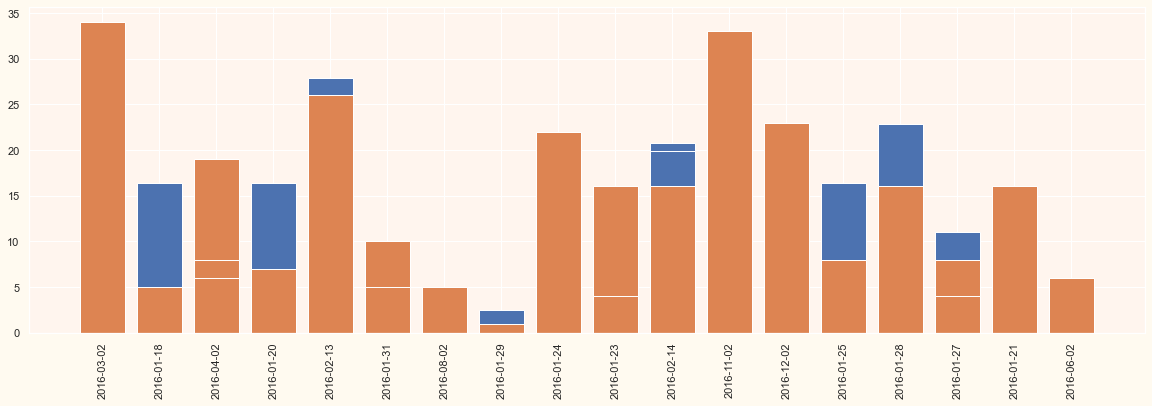

In [30]:
x = np.array(X_temp.Date.astype(str))[:30]
y1 = np.array(y_pred)[:30]
y2 = np.array(y_test)[:30]

fig, ax = plt.subplots()

ax.bar(x, y1)
ax.bar(x, y2)

ax.set_facecolor('seashell')
fig.set_figwidth(20)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor('floralwhite')
plt.xticks(rotation=90)

plt.show()

<b>Создадим таблицу с результатами и сохраним её

In [31]:
Save_df = pd.DataFrame({'Date': np.array(X_temp.Date),'Predicted': y_pred.round().astype(int), 'Facted': np.array(y_test)})

In [32]:
Save_df.head()

,Date,Predicted,Facted
0,2016-03-02,4,4
1,2016-01-18,4,2
2,2016-04-02,19,19
3,2016-01-20,16,7
4,2016-02-13,28,26


In [33]:
Save_df.to_csv('Saved_Result.csv', sep=';')